In [238]:
import numpy as np
from scipy import special
from scipy.special import factorial as fact
import matplotlib.pyplot as plt
import time
from scipy.linalg import expm as expm

cutoff = 9

In [2]:
def down(order, n):
    n_ = n - order
    n_ = np.clip(n_, 0, None)
    coeff = np.sqrt(fact(n) / fact(n_))
    coeff[(n - order) < 0] = 0
    return [coeff, n_.astype(np.int)]

def up(order, n, cutoff = 10):
    n_ = n + order
    n_[n_ > cutoff] = 0
    coeff = np.sqrt(fact(n_) / fact(n))
    coeff[(n + order) > cutoff] = 0
    return [coeff, n_.astype(np.int)]

def photonNum(order, n, cutoff = 10):
    coeff = n ** order
    return [coeff, n.astype(np.int)]

def to_2d_ndarray(a):
    if isinstance(a,(np.ndarray)):
        return a
    else:
        return np.array([[a]])
    
def Sonin_vec(n, alpha, x):
    start = time.time()
    n = to_2d_ndarray(n)
    alpha = to_2d_ndarray(alpha)
    x = to_2d_ndarray(x)        
    N = np.max(n)
    a = special.factorial(n + alpha)
    S = np.zeros([N + 1, x.shape[0], x.shape[0], n.shape[0], n.shape[0]], dtype = "float64")
    print(time.time() - start)
    for i in range(N + 1):
        if i == 0:
            S[0] = 1
        elif i == 1:
            I = np.ones(n.shape)
            I[n - i < 0] = 0
            I = I[np.newaxis, np.newaxis, :, :]
            I_bar = np.logical_not(I)
            S[1] = (alpha + 1 - x) * I + I_bar
        else:
            I = np.ones(n.shape)
            I[n - i < 0] = 0
            I = I[np.newaxis, np.newaxis, :, :]
            I_bar = np.logical_not(I).astype(int)
            res = (2 * i - 1 + alpha - x) * S[i - 1] - (i + alpha - 1) * S[i - 2]
            S[i] = res / i * I + S[i -1] * I_bar
        print(i, time.time() - start)
    print(time.time() - start)
    return S[N]

def Sonin1_vec(n, alpha, x):
    start = time.time()
    n = to_2d_ndarray(n)
    alpha = to_2d_ndarray(alpha)
    x = to_2d_ndarray(x)
    a = special.factorial(n + alpha)
    k0 = np.arange(np.max(n) + 1)
    k0 = k0[:, np.newaxis, np.newaxis]
    k = k0 * np.ones([np.max(n) + 1, n.shape[0], n.shape[0]], dtype = np.int)
    mask = np.ones(k.shape, dtype = np.int)
    for i in range(k.shape[0]):
        ind = (np.ones(n.shape) * i) > n
        mask[i, ind] = 0
    k *= mask
    S = mask * (-1) ** k * a / special.factorial(n - k) / special.factorial(k + alpha) / special.factorial(k)
    X = x ** k0
    S = S[:, np.newaxis, np.newaxis, :, :] * X[:, :, :, np.newaxis, np.newaxis] # bottle neck
    return np.sum(S, axis = 0)

def FockWignerElement_vec(xmat, pmat, l, m):
    A = np.max(np.dstack([l, m]), axis=2)
    B = np.abs(l - m).astype(np.int)
    C = np.min(np.dstack([l, m]), axis=2).astype(np.int)
    R0 = xmat**2 + pmat**2
    xmat = xmat[:, :, np.newaxis, np.newaxis]
    pmat = pmat[:, :, np.newaxis, np.newaxis]
    R = xmat**2 + pmat**2
    X = xmat + np.sign(l-m) * 1j * pmat
    factC = special.factorial(C)
    factA = special.factorial(A)
    W = 2 * (-1)**C * np.sqrt(2**(B) * factC / factA)
    W = W * np.exp(-R) * X**(B)
    S = Sonin1_vec(C, B, 2 * R0)
    return W * S

$n \leq n'$の場合  
$W_{nn'}(q, p) = \frac{2(-1)^n}{\pi} \sqrt{\frac{2^{n'} n!}{2^{n} n'!}} (q-ip)^{n'-n}e^{-(q^2+p^2)}L_{n}^{n'-n}(2(q^2+p^2))$  
$n' \leq n$の場合  
$W_{nn'}(q, p) = \frac{2(-1)^{n'}}{\pi} \sqrt{\frac{2^{n} n'!}{2^{n'} n!}} (q+ip)^{n-n'}e^{-(q^2+p^2)}L_{n'}^{n-n'}(2(q^2+p^2))$  

In [3]:
start = time.time()
a = np.ones([10000, 10000], dtype = np.complex64)
A = a * a
print(time.time() - start)

0.7436449527740479


## Multi mode化

prepare multi mode Fock state

In [4]:
modeNum = 3
cutoff = 9
def vacuumState(modeNum, cutoff):
    fockState = np.zeros([(cutoff + 1) ** modeNum])
    fockState[0] = 1
    return fockState.reshape([cutoff + 1] * modeNum)

In [5]:
def singleGate_preProcess(fockState, mode):
    cutoff = fockState.shape[-1] - 1
    fockState = np.swapaxes(fockState, mode, fockState.ndim - 1)
    return fockState.reshape(-1, cutoff + 1)

def twoModeGate_preProcess(fockState, mode1, mode2):
    cutoff = fockState.shape[-1] - 1
    fockState = np.swapaxes(fockState, mode2, modeNum - 1)
    fockState = np.swapaxes(fockState, mode1, modeNum - 2)
    return fockState.reshape(-1, cutoff + 1, cutoff + 1)

def singleGate_postProcess(fockState, mode, modeNum):
    cutoff = fockState.shape[-1] - 1
    fockState = fockState.reshape([cutoff + 1] * modeNum)
    return np.swapaxes(fockState, mode, modeNum - 1)

def twoModeGate_postProcess(fockState, mode1, mode2, modeNum):
    cutoff = fockState.shape[-1] - 1
    fockState = fockState.reshape([cutoff + 1] * modeNum)
    fockState = np.swapaxes(fockState, mode1, modeNum - 2)
    fockState = np.swapaxes(fockState, mode2, modeNum - 1)
    return fockState

def exp_annihiration(fockState, alpha, order = 1, cutoff = 10):
    ind = np.arange(fockState.shape[-1])
    state = np.zeros(fockState.shape) + 0j
    for i in range(cutoff + 1):
        tmp = down(order * i, ind)
        state[:, tmp[1]] += tmp[0] * fockState[:, ind] / special.factorial([i]) * alpha ** i
    return state

def exp_creation(fockState, alpha, order = 1, cutoff = 10):
    ind = np.arange(fockState.shape[-1])
    state = np.zeros(fockState.shape) + 0j
    for i in range(cutoff + 1):
        tmp = up(order * i, ind, cutoff = cutoff)
        state[:, tmp[1]] += tmp[0] * fockState[:, ind] / special.factorial([i]) * alpha ** i
    return state

def exp_photonNum(fockState, alpha, order = 1, cutoff = 10):
    ind = np.arange(fockState.shape[-1])
    state = np.zeros(fockState.shape) + 0j
    for i in range(cutoff + 1):
        tmp =  photonNum(order * i, ind, cutoff)  # (order, n)
        state[:, tmp[1]] += tmp[0] * fockState[:, ind] / special.factorial([i]) * alpha ** i
    return state

In [6]:
def reduceState(fockState, mode):
    modeNum = fockState.ndim
    cutoff = fockState.shape[-1] - 1
    fockState = np.swapaxes(fockState, mode, 0)
    fockState = fockState.flatten()
    rho = np.outer(np.conj(fockState), fockState)
    for i in range(modeNum - 1):
        rho = partialTrace(rho, cutoff)
    return  rho

def partialTrace(rho, cutoff):
    split = np.int(rho.shape[-1] / (cutoff + 1))
    rho = np.array(np.split(rho, split, axis = -1))
    rho = np.array(np.split(rho, split, axis = -2))
    rho = np.trace(rho, axis1 = -2, axis2 = -1)
    return  rho

In [7]:
def displacement(fockState, mode, alpha, cutoff):
    modeNum = fockState.ndim
    state = singleGate_preProcess(fockState, mode)
    state = exp_annihiration(state, -np.conj(alpha), cutoff = cutoff)
    state = exp_creation(state, alpha, cutoff = cutoff)
    state = singleGate_postProcess(state, mode, modeNum)
    return state * np.exp(-np.abs(alpha)**2 / 2)

### 試してみる

In [8]:
alpha1 = (1 - 1j)
mode1 = 0
alpha2 = (1 + 1j)
mode2 = 1
modeNum = 2
cutoff = 20
fockState = vacuumState(modeNum, cutoff)
state = displacement(fockState, mode1, alpha1, cutoff)
state = displacement(state, mode2, alpha2, cutoff)
# reducedState0 = reduceState(state, 0)
# reducedState1 = reduceState(state, 1)
# reducedState2 = reduceState(state, 2)

# print(reducedState0)
# print(reducedState1)
# print(reducedState2)

In [9]:
def FockWigner_vec(xmat, pmat, fockState, mode, tol=1e-10):
    if fockState.ndim < mode + 1:
        raise  ValueError("The mode is not exist.")
    if fockState.ndim > 1:
        rho = reduceState(fockState, mode)
    else:
        rho = np.outer(np.conj(fockState), fockState)
    dim = len(fockState)
    grid = np.indices([dim, dim])
    W = FockWignerElement_vec(xmat, pmat, grid[0], grid[1])
    W = rho * W
    W = np.sum(np.sum(W, axis = -1), axis = -1)
    if np.max(np.imag(W)) < tol:
        W = np.real(W)
    else:
        raise ValueError("Wigner plot has imaginary value.")
    return W

0.7927761077880859


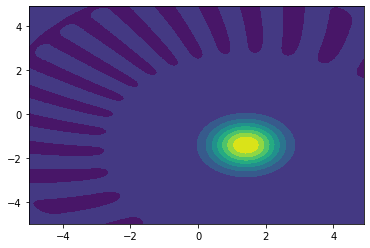

In [10]:
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
m = len(x)
xx, pp = np.meshgrid(x, p)
xi_array = np.dstack((pp, xx))
start = time.time()
        
W = FockWigner_vec(xx, pp, state, 0)

h = plt.contourf(x, p, W)
t = time.time() - start
print(t)

## Kerr gate 

$H = \hbar \frac{\chi}{2} (\hat{a}^{\dagger})^2 \hat{a}^2$

$K = \exp{(\frac{i}{\hbar}H)} = \exp{(i\frac{\chi}{2} (\hat{a}^{\dagger})^2 \hat{a}^2)} = \exp{(i\frac{\chi}{2} \hat{a}^{\dagger} \hat{n} \hat{a})}$

In [11]:
def squeeze(fockState, mode, r, phi, cutoff):
    G = np.exp(2 * 1j * phi) * np.tanh(r)
    modeNum = fockState.ndim
    state = singleGate_preProcess(fockState, mode)
    state = exp_annihiration(state, np.conj(G) / 2, order = 2, cutoff = cutoff)
    state = exp_photonNum(state, -np.log(np.cosh(r)), cutoff = cutoff)
    state = exp_creation(state, -G / 2, order = 2, cutoff = cutoff)
    state = singleGate_postProcess(state, mode, modeNum)
    return state / np.sqrt(np.cosh(r))

In [240]:
A = np.array([[1, 0], [0, 1]])
expm(A)

array([[2.71828183, 0.        ],
       [0.        , 2.71828183]])

In [197]:
def AAaa(fockState, cutoff):
    order = 2
    ind = np.arange(fockState.shape[-1])
    state = np.zeros(fockState.shape) + 0j
    state0 = np.zeros(fockState.shape) + 0j
    tmp = down(order, ind)
    state0[:, tmp[1]] = tmp[0] * fockState[:, ind]
    state0[:, (cutoff - order):cutoff] = 0
    
    tmp = up(order, ind, cutoff = cutoff)
    state[:, tmp[1]] = tmp[0] * state0[:, ind]
    state[:, 0:order] = 0
    return state

def pow_AAaa(fockState, n, cutoff):
    state = np.copy(fockState)
    if n == 0:
        return state
    else:
        for i in range(n):
            state = AAaa(state, cutoff)
        return state

def exp_AAaa(fockState, alpha, cutoff):
    state = np.zeros(fockState.shape) + 0j
    precision = 5
    # precisionが小さいと結果が収束しない。逆に言うと、小さくても収束する形でHamiltonianを実装する必要がある。
    # もしくは、指数関数の数値計算で行っているような工夫が必要。
    for i in range(precision * cutoff + 1):
        tmpstate = np.copy(fockState)
        tmpstate = pow_AAaa(tmpstate, i, cutoff)
        tmpstate = tmpstate / special.factorial([i]) * (alpha ** i)
        state += tmpstate
        #print(np.sum(np.abs(state)**2))
    return state

def exp_AAaa2(fockState, alpha, cutoff):
    state = np.zeros(fockState.shape) + 0j
    for i in range(3 * cutoff + 1):
        tmpstate = np.copy(fockState)
        tmpstate = pow_AAaa(tmpstate, i, cutoff)
        tmpstate = tmpstate / special.factorial([i]) * (alpha ** i)
        state += tmpstate
        #print(np.sum(np.abs(state)**2))
    return state

In [235]:
def exp_maclaurin(x):
    n = 15
    res = 0
    for i in range(n):
        res += x ** i / special.factorial(i)
    return res

x = 20
r = exp_maclaurin(x)
print(r, np.abs(r))
print(np.exp(x), np.abs(np.exp(x)))

50876499.43526256 50876499.43526256
485165195.4097903 485165195.4097903


In [198]:
def kerr(fockState, mode, chi, cutoff):
    modeNum = fockState.ndim
    state = singleGate_preProcess(fockState, mode)
    state = exp_AAaa(state, 1j * chi / 2, cutoff)
    state = singleGate_postProcess(state, mode, modeNum)
    return state

In [199]:
chi = 0.2
alpha = 1
mode = 0
modeNum = 1
cutoff = 20
state = vacuumState(modeNum, cutoff)
print(np.sum(np.abs(state)**2))
state = displacement(state, mode, alpha, cutoff)
state = kerr(state, mode, chi, cutoff)
print(np.sum(np.abs(state)**2))

1.0
1.0


0.6553080081939697


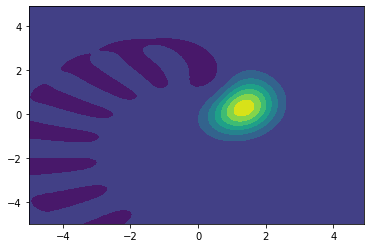

In [200]:
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
m = len(x)
xx, pp = np.meshgrid(x, p)
xi_array = np.dstack((pp, xx))
start = time.time()
        
W1 = FockWigner_vec(xx, pp, state, 0)
#W2 = FockWigner_vec(xx, pp, state, 1)

h = plt.contourf(x, p, W1)
t = time.time() - start
print(t)

## For Check

In [48]:
import sys
sys.path.append('../')

import photonqat as pq
import strawberryfields as sf
from strawberryfields.ops import *

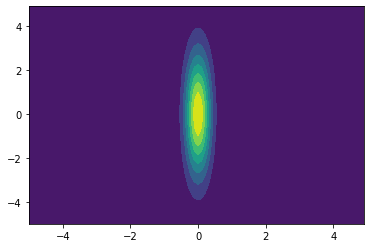

mu0 = [0. 0.]
cov0 = [[0.06766764 0.        ]
 [0.         3.69452805]]


In [55]:
G = pq.Gaussian_trans(3)
G.Xsqueeze(0, 1)

G.plotGaussianWigner(0) # plot
print('mu0 =', G.mean(0)) # mu of qumode 0
print('cov0 =', G.cov(0)) # covarince of qumode 1

In [1264]:
eng = sf.Engine(backend="gaussian")
gaussian = sf.Program(3)

with gaussian.context as q:
        sf.hbar = 1
        # prepare the initial states
        Dgate(alpha) | q[2] # displacement gate
        BSgate(np.pi/4, 0) | (q[1], q[2])  # 50-50 beamsplitter


results = eng.run(gaussian)
mu0, cov0 = results.state.reduced_gaussian([0])
mu1, cov1 = results.state.reduced_gaussian([1])
mu2, cov2 = results.state.reduced_gaussian([2])
print('mu0 =', mu0)
print('mu1 =', mu1)
print('mu2 =', mu2)

mu0 = [0. 0.]
mu1 = [-1. -1.]
mu2 = [1. 1.]


In [80]:
A = np.array([1, 0, 0])
B = np.array([0, 1, 0])
C = np.array([0, 1, 1])
s = np.tensordot(A, B, axes=0)
print(s)
s = np.tensordot(s, C, axes=0)
s

[[0 1 0]
 [0 0 0]
 [0 0 0]]


array([[[0, 0, 0],
        [0, 1, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])